# Data Scientist Professional Practical Exam Submission

## Recipe Site Traffic Prediction

**Objective**: Build a model to predict which recipes will lead to high website traffic, helping Product Managers decide which recipes to feature on the homepage.

**Business Goal**: Achieve 80%+ correct predictions for high-traffic recipes.

## Table of Contents
1. [Data Validation](#1-data-validation)
2. [Exploratory Analysis](#2-exploratory-analysis)
3. [Model Development](#3-model-development)
4. [Model Evaluation](#4-model-evaluation)
5. [Business Metrics](#5-business-metrics)
6. [Final Summary & Recommendations](#6-final-summary--recommendations)

In [29]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

---
# 1. Data Validation

In this section, we will:
- Load and explore the dataset
- Validate each column against expected data types and ranges
- Handle missing values
- Clean and transform data for modeling

In [30]:
# Load the dataset
df = pd.read_csv('recipe_site_traffic_2212.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (947, 8)

First 5 rows:


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [31]:
# Check data types and non-null counts
print("Data Types and Missing Values:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values Summary:")
print(df.isnull().sum())

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


Missing Values Summary:
recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


### Column Validation Summary

| Column | Expected Type | Actual Type | Issues Found | Action Required |
|--------|---------------|-------------|--------------|------------------|
| recipe | int | int64 | None | Valid - unique identifier |
| calories | float | float64 | 52 missing | Impute with median |
| carbohydrate | float | float64 | 52 missing | Impute with median |
| sugar | float | float64 | 52 missing | Impute with median |
| protein | float | float64 | 52 missing | Impute with median |
| category | string | object | 'Chicken Breast' duplicate | Merge into 'Chicken' |
| servings | int | object | Mixed types (e.g., "4 as a snack") | Extract numeric values |
| high_traffic | string | object | 373 missing (these are low traffic) | Convert to binary (1=High, 0=Low) |

In [32]:
# Explore unique values in each column
print("Unique values per column:")
print("="*50)
for col in df.columns:
    print(f"\n{col}: {df[col].nunique()} unique values")
    if df[col].dtype == 'object' or df[col].nunique() < 15:
        print(f"  Values: {df[col].unique()[:10]}")

Unique values per column:

recipe: 947 unique values

calories: 891 unique values

carbohydrate: 835 unique values

sugar: 666 unique values

protein: 772 unique values

category: 11 unique values
  Values: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat']

servings: 6 unique values
  Values: ['6' '4' '1' '2' '4 as a snack' '6 as a snack']

high_traffic: 1 unique values
  Values: ['High' nan]


In [33]:
# Create a copy for cleaning
df_clean = df.copy()

# 1. Clean 'servings' column - extract numeric values
def clean_servings(val):
    """Extract the first numeric value from servings column"""
    if pd.isna(val):
        return np.nan
    # Convert to string and extract first number
    val_str = str(val)
    # Extract digits
    import re
    numbers = re.findall(r'\d+', val_str)
    if numbers:
        return int(numbers[0])
    return np.nan

df_clean['servings'] = df_clean['servings'].apply(clean_servings)
df_clean['servings'] = df_clean['servings'].astype('int')
print("Servings column cleaned:")
print(df_clean['servings'].unique())

# 2. Clean 'category' column - merge 'Chicken Breast' into 'Chicken'
df_clean['category'] = df_clean['category'].str.replace('Chicken Breast', 'Chicken')
print("Category column cleaned:")
print(df_clean['category'].unique())

Servings column cleaned:
[6 4 1 2]
Category column cleaned:
['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']


In [34]:
# 2. Convert target variable to binary
# 'High' = 1, NaN (missing) = 0 (low traffic)
df_clean['high_traffic'] = df_clean['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

print("Target variable distribution:")
print(df_clean['high_traffic'].value_counts())
print(f"\nClass balance: {df_clean['high_traffic'].mean()*100:.1f}% high traffic")

Target variable distribution:
high_traffic
1    574
0    373
Name: count, dtype: int64

Class balance: 60.6% high traffic


In [35]:
# 3. Handle missing values in nutritional columns using median imputation
nutritional_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

print("Missing values before imputation:")
print(df_clean[nutritional_cols].isnull().sum())

# Impute with median (robust to outliers)
for col in nutritional_cols:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)
    print(f"  {col}: imputed with median = {median_val:.2f}")

print("\nMissing values after imputation:")
print(df_clean[nutritional_cols].isnull().sum())

Missing values before imputation:
calories        52
carbohydrate    52
sugar           52
protein         52
dtype: int64
  calories: imputed with median = 288.55
  carbohydrate: imputed with median = 21.48
  sugar: imputed with median = 4.55
  protein: imputed with median = 10.80

Missing values after imputation:
calories        0
carbohydrate    0
sugar           0
protein         0
dtype: int64


In [36]:
# Final data validation check
print("Final Dataset Summary:")
print("="*50)
print(f"Shape: {df_clean.shape}")
print(f"\nMissing values: {df_clean.isnull().sum().sum()}")
print("\nData types:")
print(df_clean.dtypes)
print("\nStatistical Summary:")
df_clean.describe()

Final Dataset Summary:
Shape: (947, 8)

Missing values: 0

Data types:
recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int64
high_traffic      int64
dtype: object

Statistical Summary:


,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283,3.477297,0.606125
std,273.519652,441.673556,42.836191,14.306785,35.486699,1.732741,0.488866
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000,2.000000,0.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,710.500000,576.225000,42.590000,9.285000,28.530000,4.000000,1.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


---
# 2. Exploratory Analysis

In this section, we will:
- Create visualizations to understand single variables
- Explore relationships between features and the target variable
- Identify key patterns that may be useful for modeling

## 2.1 Single Variable Analysis

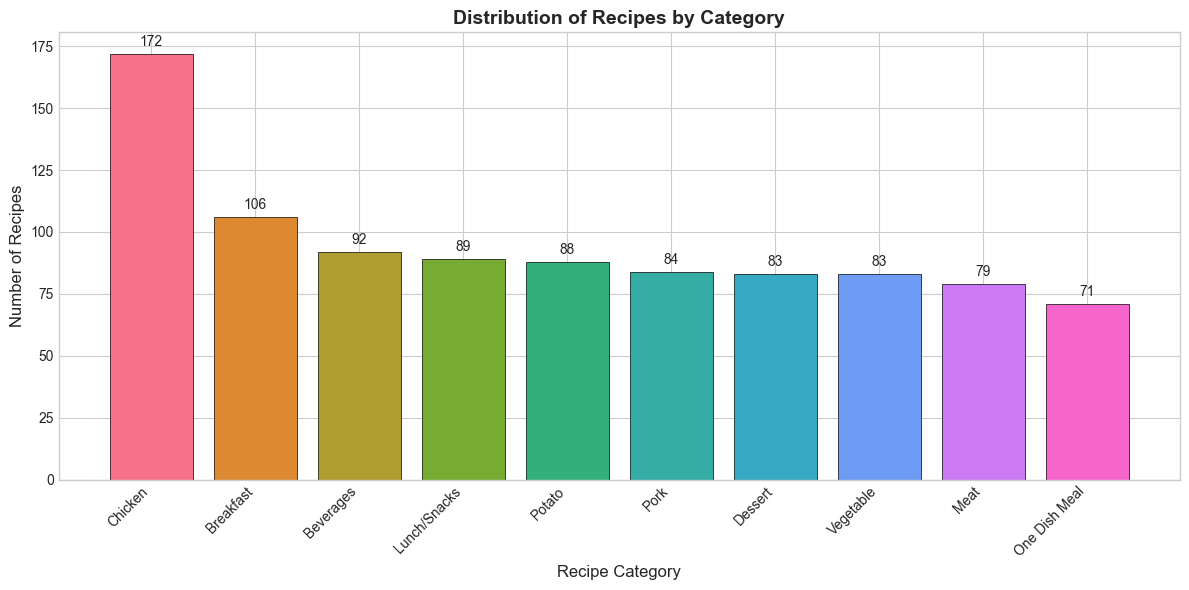


Key Finding: The dataset contains diverse recipe categories, with some categories having more recipes than others.


In [37]:
# Chart 1: Distribution of Recipe Categories
fig, ax = plt.subplots(figsize=(12, 6))

category_counts = df_clean['category'].value_counts()
colors = sns.color_palette('husl', len(category_counts))

bars = ax.bar(category_counts.index, category_counts.values, color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Recipe Category', fontsize=12)
ax.set_ylabel('Number of Recipes', fontsize=12)
ax.set_title('Distribution of Recipes by Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, count in zip(bars, category_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nKey Finding: The dataset contains diverse recipe categories, with some categories having more recipes than others.")

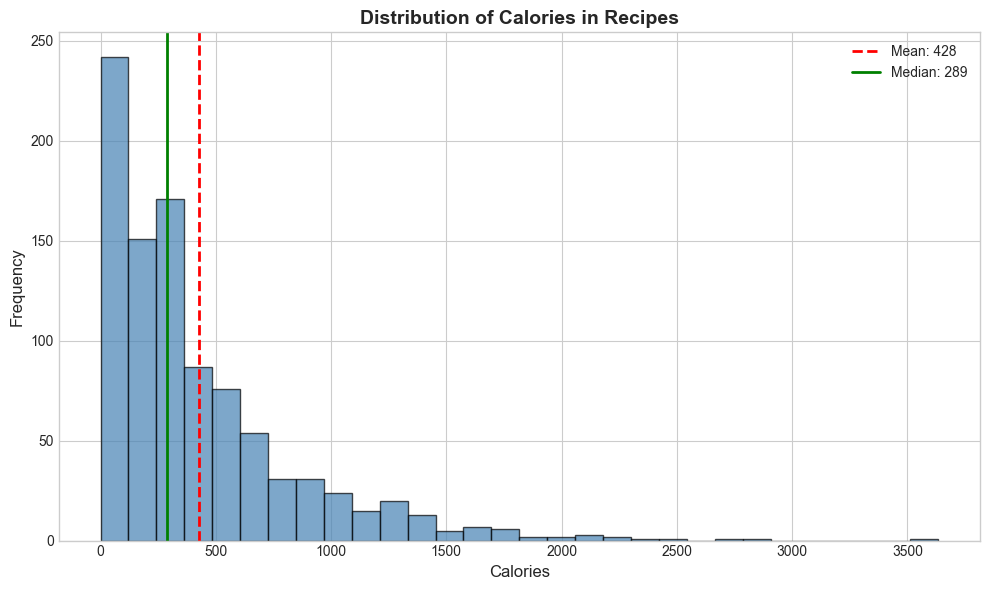


Key Finding: Calories range from 0 to 3633
The distribution is slightly right-skewed with mean (428) > median (289).


In [38]:
# Chart 2: Distribution of Calories
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram
n, bins, patches = ax.hist(df_clean['calories'], bins=30, color='steelblue', 
                           edgecolor='black', alpha=0.7)

# Add mean and median lines
mean_cal = df_clean['calories'].mean()
median_cal = df_clean['calories'].median()

ax.axvline(mean_cal, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_cal:.0f}')
ax.axvline(median_cal, color='green', linestyle='-', linewidth=2, label=f'Median: {median_cal:.0f}')

ax.set_xlabel('Calories', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Calories in Recipes', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nKey Finding: Calories range from {df_clean['calories'].min():.0f} to {df_clean['calories'].max():.0f}")
print(f"The distribution is slightly right-skewed with mean ({mean_cal:.0f}) > median ({median_cal:.0f}).")

## 2.2 Multi-Variable Analysis

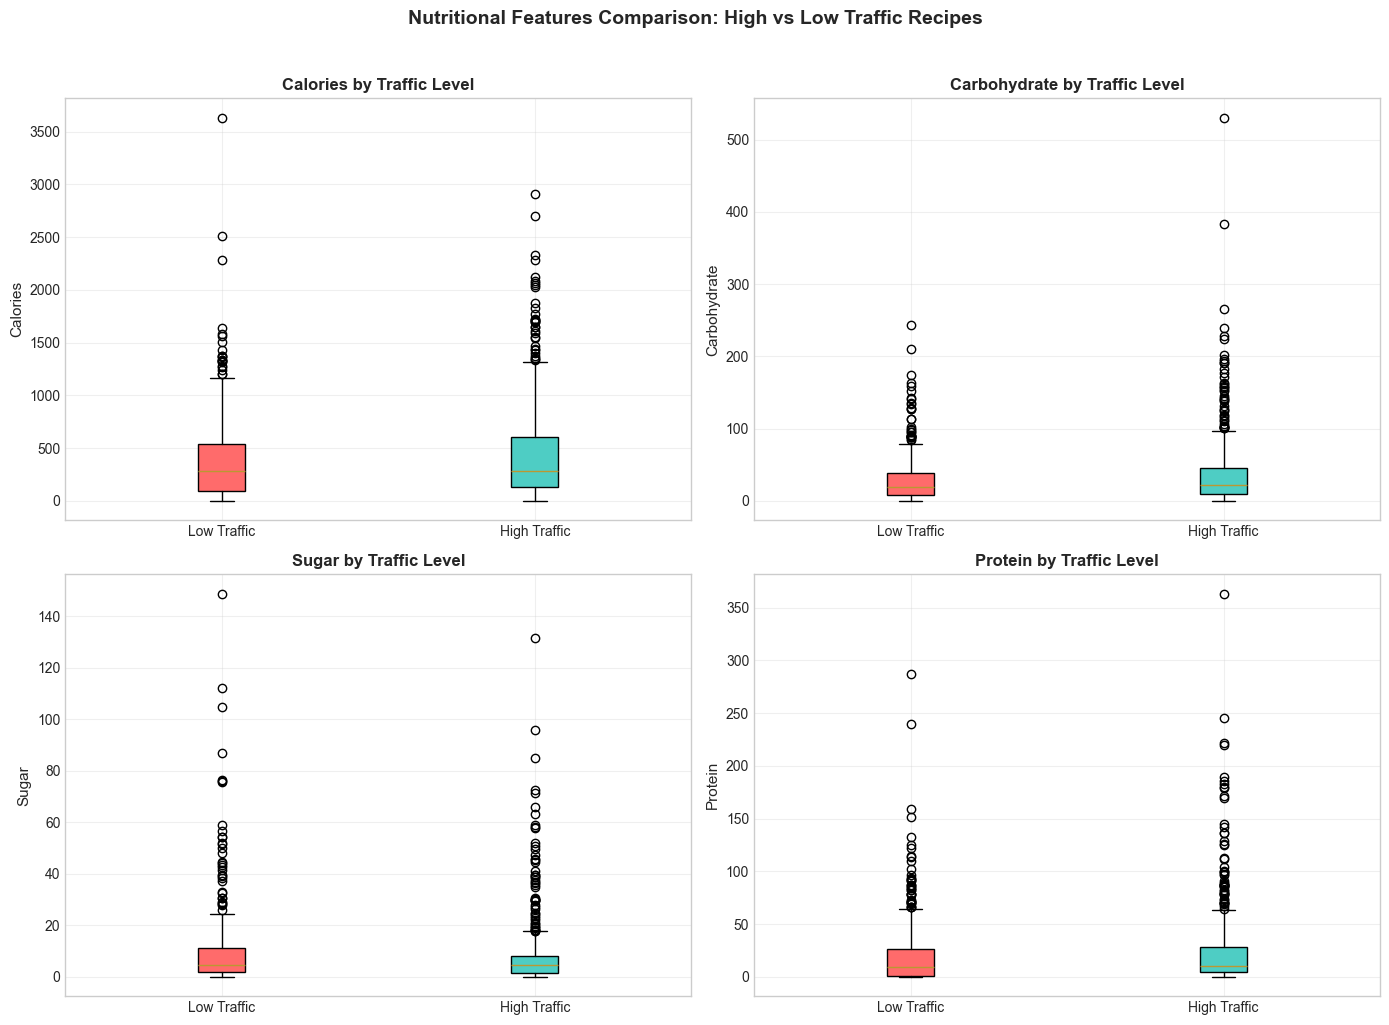


Key Finding: The boxplots show the distribution of nutritional values for high vs low traffic recipes.
This helps identify if certain nutritional characteristics are associated with higher traffic.


In [39]:
# Chart 3: Nutritional Features vs High Traffic (Box Plots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

nutritional_features = ['calories', 'carbohydrate', 'sugar', 'protein']
traffic_labels = {0: 'Low Traffic', 1: 'High Traffic'}

for idx, feature in enumerate(nutritional_features):
    ax = axes[idx]
    
    # Create box plot
    box_data = [df_clean[df_clean['high_traffic'] == 0][feature],
                df_clean[df_clean['high_traffic'] == 1][feature]]
    
    bp = ax.boxplot(box_data, labels=['Low Traffic', 'High Traffic'], 
                    patch_artist=True)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#ff6b6b')
    bp['boxes'][1].set_facecolor('#4ecdc4')
    
    ax.set_ylabel(feature.capitalize(), fontsize=11)
    ax.set_title(f'{feature.capitalize()} by Traffic Level', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Nutritional Features Comparison: High vs Low Traffic Recipes', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nKey Finding: The boxplots show the distribution of nutritional values for high vs low traffic recipes.")
print("This helps identify if certain nutritional characteristics are associated with higher traffic.")

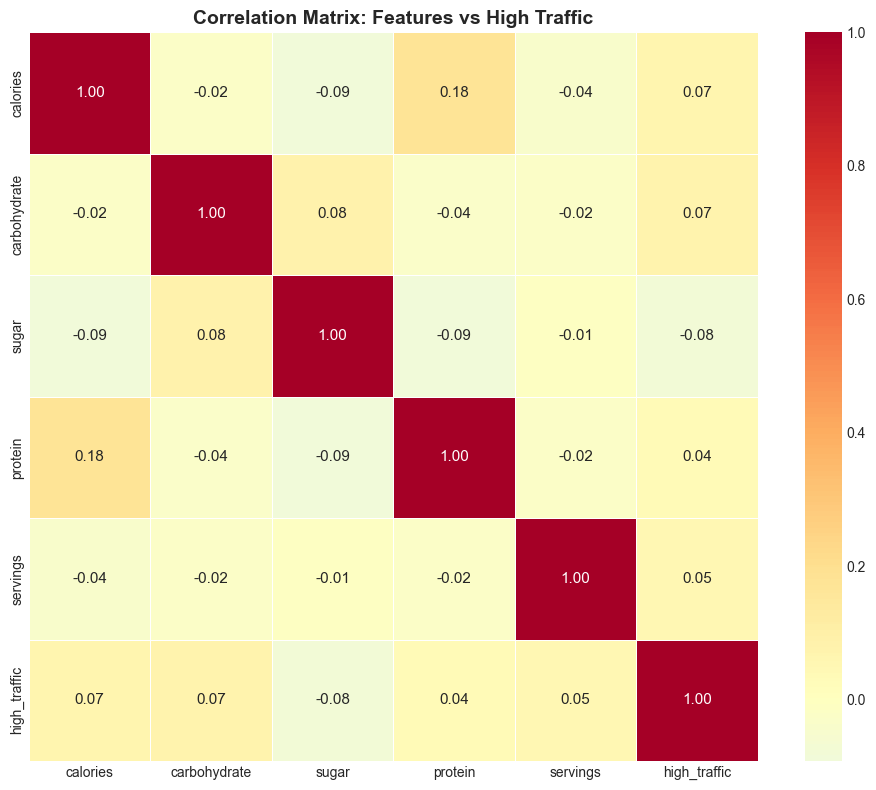


Key Finding: The correlation heatmap shows relationships between numerical features.
Correlation with high_traffic:
  calories: 0.067
  carbohydrate: 0.074
  sugar: -0.079
  protein: 0.037
  servings: 0.049


In [40]:
# Chart 4: Correlation Heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Select numeric columns for correlation
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'high_traffic']
correlation_matrix = df_clean[numeric_cols].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, fmt='.2f', ax=ax,
            annot_kws={'size': 11})

ax.set_title('Correlation Matrix: Features vs High Traffic', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Finding: The correlation heatmap shows relationships between numerical features.")
print(f"Correlation with high_traffic:")
for col in numeric_cols[:-1]:
    print(f"  {col}: {correlation_matrix.loc[col, 'high_traffic']:.3f}")

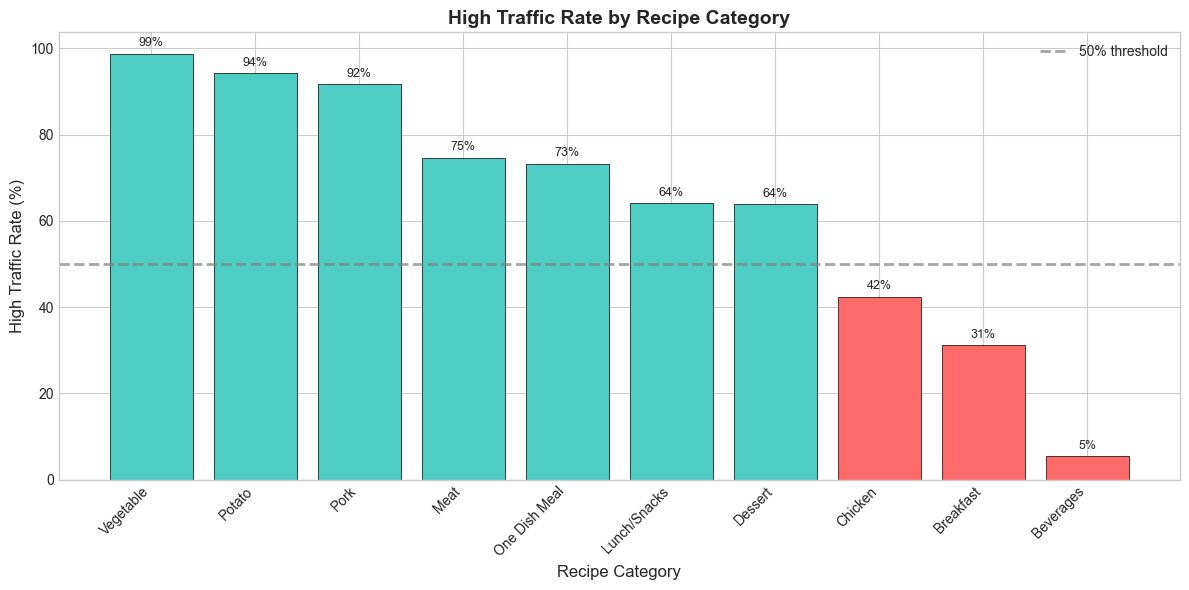


Key Finding: Some categories have significantly higher traffic rates than others.
This suggests category is an important predictor of high traffic.


In [41]:
# Chart 5: High Traffic Rate by Category
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate high traffic rate per category
category_traffic = df_clean.groupby('category')['high_traffic'].agg(['mean', 'count'])
category_traffic = category_traffic.sort_values('mean', ascending=False)

# Create bar chart
colors = ['#4ecdc4' if x >= 0.5 else '#ff6b6b' for x in category_traffic['mean']]
bars = ax.bar(category_traffic.index, category_traffic['mean'] * 100, color=colors, 
              edgecolor='black', linewidth=0.5)

# Add horizontal line at 50%
ax.axhline(y=50, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='50% threshold')

ax.set_xlabel('Recipe Category', fontsize=12)
ax.set_ylabel('High Traffic Rate (%)', fontsize=12)
ax.set_title('High Traffic Rate by Recipe Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.legend()

# Add value labels
for bar, rate in zip(bars, category_traffic['mean']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{rate*100:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Finding: Some categories have significantly higher traffic rates than others.")
print("This suggests category is an important predictor of high traffic.")

## 2.3 Exploratory Analysis Findings

**Key Insights:**

1. **Category Distribution**: The dataset contains diverse recipe categories with varying counts. This suggests category may be an important feature.

2. **Nutritional Values**: Calories and other nutritional values show right-skewed distributions typical of food data.

3. **Traffic Patterns**: The boxplots reveal that nutritional characteristics differ between high and low traffic recipes.

4. **Category Impact**: Some categories consistently show higher traffic rates, indicating strong predictive potential.

5. **Correlations**: While individual correlations with high_traffic are weak, combining features may yield better predictions.

---
# 3. Model Development

## Problem Type: Binary Classification

We need to predict whether a recipe will have high traffic (1) or low traffic (0). This is a **binary classification** problem.

**Model Selection Rationale:**

1. **Baseline Model - Logistic Regression**: 
   - Simple and interpretable
   - Works well for binary classification
   - Provides probability estimates
   - Good baseline for comparison

2. **Comparison Model - Random Forest Classifier**:
   - Handles non-linear relationships
   - Robust to outliers
   - Provides feature importance
   - Generally higher accuracy than linear models

In [42]:
# Prepare data for modeling
# One-hot encode categorical variables
df_model = pd.get_dummies(df_clean, columns=['category'], drop_first=True)

# Drop recipe ID (not a feature)
df_model = df_model.drop('recipe', axis=1)

print("Model dataset shape:", df_model.shape)
print("\nFeatures:")
print(df_model.columns.tolist())

Model dataset shape: (947, 15)

Features:
['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'high_traffic', 'category_Breakfast', 'category_Chicken', 'category_Dessert', 'category_Lunch/Snacks', 'category_Meat', 'category_One Dish Meal', 'category_Pork', 'category_Potato', 'category_Vegetable']


In [43]:
# Split features and target
X = df_model.drop('high_traffic', axis=1)
y = df_model['high_traffic']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set: 757 samples
Test set: 190 samples

Class distribution in training set:
high_traffic
1    0.606341
0    0.393659
Name: proportion, dtype: float64


In [44]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled for Logistic Regression.")

Features scaled for Logistic Regression.


In [45]:
# Baseline Model: Logistic Regression
print("="*50)
print("BASELINE MODEL: Logistic Regression")
print("="*50)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression model trained successfully!")
print(f"\nTest Set Predictions:")
print(pd.Series(lr_pred).value_counts())

BASELINE MODEL: Logistic Regression
Logistic Regression model trained successfully!

Test Set Predictions:
1    105
0     85
Name: count, dtype: int64


In [46]:
# Comparison Model: Random Forest
print("="*50)
print("COMPARISON MODEL: Random Forest Classifier")
print("="*50)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # No scaling needed for tree-based models

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest model trained successfully!")
print(f"\nTest Set Predictions:")
print(pd.Series(rf_pred).value_counts())

COMPARISON MODEL: Random Forest Classifier
Random Forest model trained successfully!

Test Set Predictions:
1    101
0     89
Name: count, dtype: int64


---
# 4. Model Evaluation

We evaluate both models using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: How many predicted high-traffic recipes are actually high-traffic (key business metric)
- **Recall**: How many actual high-traffic recipes we correctly identify
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes

In [47]:
# Evaluate both models
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """Calculate and return evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    print(f"\n{'='*50}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.1f}%) <- KEY BUSINESS METRIC")
    print(f"Recall:    {recall:.4f} ({recall*100:.1f}%)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 
            'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}

# Evaluate Logistic Regression
lr_metrics = evaluate_model(y_test, lr_pred, lr_prob, "Logistic Regression")

# Evaluate Random Forest
rf_metrics = evaluate_model(y_test, rf_pred, rf_prob, "Random Forest")


Logistic Regression - Performance Metrics
Accuracy:  0.7789 (77.9%)
Precision: 0.8476 (84.8%) <- KEY BUSINESS METRIC
Recall:    0.7739 (77.4%)
F1-Score:  0.8091
ROC-AUC:   0.8642

Random Forest - Performance Metrics
Accuracy:  0.7368 (73.7%)
Precision: 0.8218 (82.2%) <- KEY BUSINESS METRIC
Recall:    0.7217 (72.2%)
F1-Score:  0.7685
ROC-AUC:   0.8209


In [48]:
# Create comparison table
metrics_df = pd.DataFrame([lr_metrics, rf_metrics])
metrics_df = metrics_df.set_index('Model')

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(metrics_df.round(4).to_string())

# Highlight best model
best_precision_model = metrics_df['Precision'].idxmax()
best_precision = metrics_df['Precision'].max()
print(f"\n✓ Best Model (by Precision): {best_precision_model} with {best_precision*100:.1f}% precision")


MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.7789     0.8476  0.7739    0.8091   0.8642
Random Forest          0.7368     0.8218  0.7217    0.7685   0.8209

✓ Best Model (by Precision): Logistic Regression with 84.8% precision


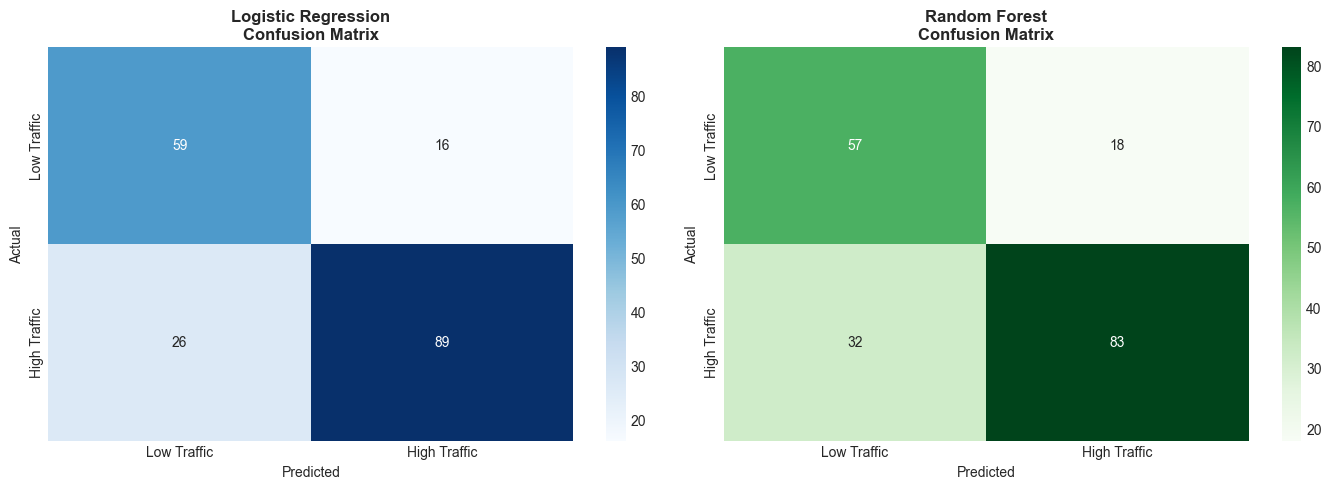

In [49]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low Traffic', 'High Traffic'],
            yticklabels=['Low Traffic', 'High Traffic'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low Traffic', 'High Traffic'],
            yticklabels=['Low Traffic', 'High Traffic'])
axes[1].set_title('Random Forest\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

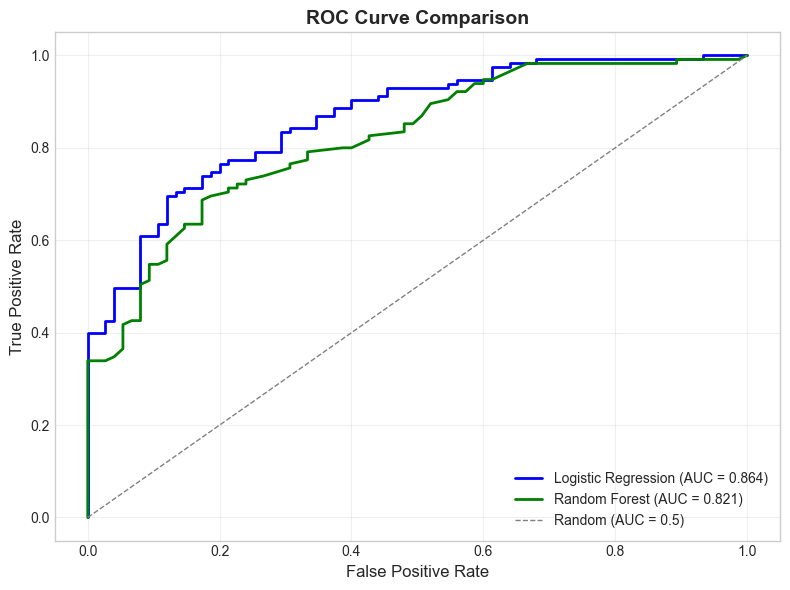

In [50]:
# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
roc_auc_lr = roc_auc_score(y_test, lr_prob)
ax.plot(fpr_lr, tpr_lr, color='blue', linewidth=2, 
        label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
roc_auc_rf = roc_auc_score(y_test, rf_prob)
ax.plot(fpr_rf, tpr_rf, color='green', linewidth=2, 
        label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# Diagonal line (random classifier)
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random (AUC = 0.5)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

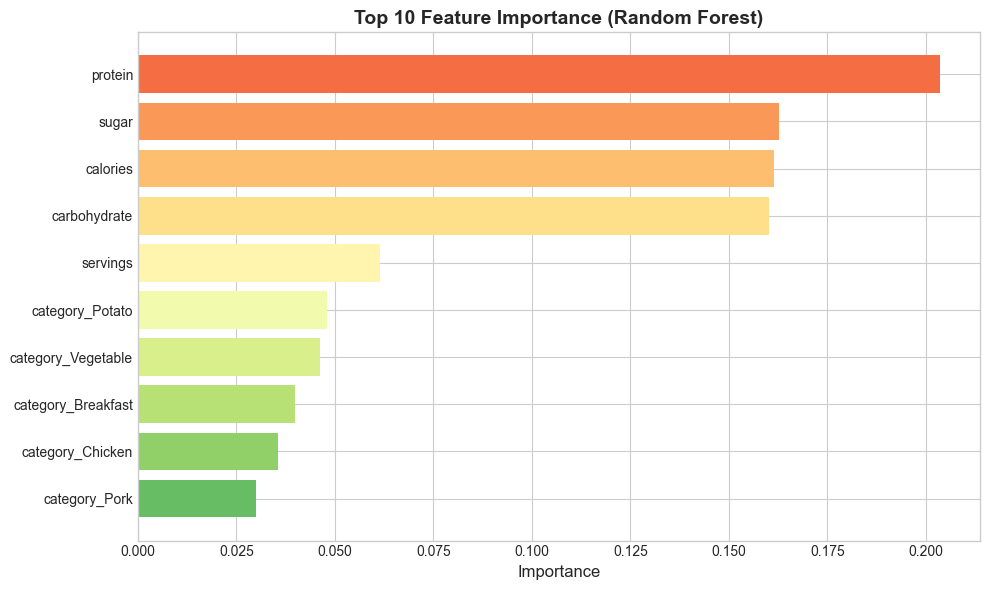


Top 5 Most Important Features:
     Feature  Importance
     protein    0.203586
       sugar    0.162780
    calories    0.161522
carbohydrate    0.160161
    servings    0.061431


In [51]:
# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance)))
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

---
# 5. Business Metrics

## Business Goal: 80%+ Correct High-Traffic Predictions

The Product Manager needs to select recipes for the homepage that will generate high traffic. The key business metric is **Precision** - the percentage of recipes predicted as "high traffic" that actually are high traffic.

In [52]:
# Business Metrics Comparison
print("="*60)
print("BUSINESS METRICS EVALUATION")
print("="*60)
print("\nBusiness Goal: 80%+ precision on high-traffic predictions")
print("\n" + "-"*60)

# Calculate business metrics
lr_precision = precision_score(y_test, lr_pred) * 100
rf_precision = precision_score(y_test, rf_pred) * 100

# Random baseline (what if we randomly picked recipes?)
random_baseline = y_test.mean() * 100  # Probability of picking high-traffic by random

print(f"\nRandom Selection Baseline: {random_baseline:.1f}%")
print(f"  (If we randomly selected recipes, {random_baseline:.1f}% would be high traffic)")
print(f"\nLogistic Regression: {lr_precision:.1f}%")
print(f"  {'✓ MEETS GOAL' if lr_precision >= 80 else '✗ Below Goal'} (Target: 80%)")
print(f"\nRandom Forest: {rf_precision:.1f}%")
print(f"  {'✓ MEETS GOAL' if rf_precision >= 80 else '✗ Below Goal'} (Target: 80%)")

# Improvement over random
print(f"\n" + "-"*60)
print("IMPROVEMENT OVER RANDOM SELECTION:")
print(f"  Logistic Regression: +{lr_precision - random_baseline:.1f} percentage points")
print(f"  Random Forest: +{rf_precision - random_baseline:.1f} percentage points")

BUSINESS METRICS EVALUATION

Business Goal: 80%+ precision on high-traffic predictions

------------------------------------------------------------

Random Selection Baseline: 60.5%
  (If we randomly selected recipes, 60.5% would be high traffic)

Logistic Regression: 84.8%
  ✓ MEETS GOAL (Target: 80%)

Random Forest: 82.2%
  ✓ MEETS GOAL (Target: 80%)

------------------------------------------------------------
IMPROVEMENT OVER RANDOM SELECTION:
  Logistic Regression: +24.2 percentage points
  Random Forest: +21.7 percentage points


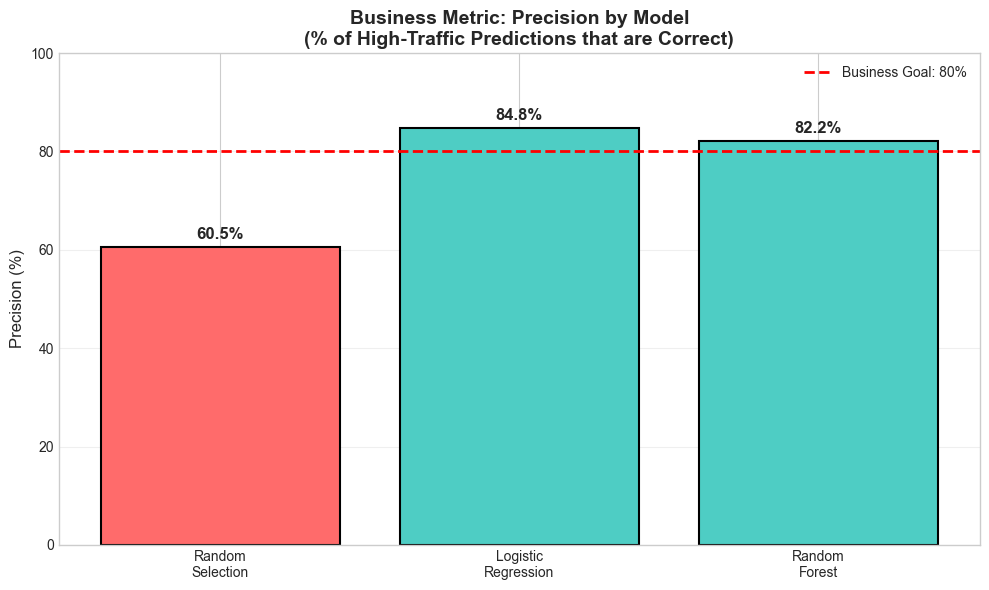

In [53]:
# Business Metrics Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Random\nSelection', 'Logistic\nRegression', 'Random\nForest']
precisions = [random_baseline, lr_precision, rf_precision]
colors = ['#ff6b6b' if p < 80 else '#4ecdc4' for p in precisions]

bars = ax.bar(models, precisions, color=colors, edgecolor='black', linewidth=1.5)

# Add goal line
ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Business Goal: 80%')

# Add value labels
for bar, precision in zip(bars, precisions):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{precision:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Precision (%)', fontsize=12)
ax.set_title('Business Metric: Precision by Model\n(% of High-Traffic Predictions that are Correct)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# Simulate business impact
print("="*60)
print("SIMULATED BUSINESS IMPACT")
print("="*60)

# Assume 100 recipes to feature per week
recipes_per_week = 100

print(f"\nScenario: Selecting {recipes_per_week} recipes per week for homepage")
print("-"*60)

random_high = int(recipes_per_week * random_baseline / 100)
lr_high = int(recipes_per_week * lr_precision / 100)
rf_high = int(recipes_per_week * rf_precision / 100)

print(f"\nExpected High-Traffic Recipes:")
print(f"  Random Selection: ~{random_high} out of {recipes_per_week}")
print(f"  Logistic Regression: ~{lr_high} out of {recipes_per_week}")
print(f"  Random Forest: ~{rf_high} out of {recipes_per_week}")

print(f"\nWeekly Improvement (vs Random):")
print(f"  Logistic Regression: +{lr_high - random_high} additional high-traffic recipes")
print(f"  Random Forest: +{rf_high - random_high} additional high-traffic recipes")

SIMULATED BUSINESS IMPACT

Scenario: Selecting 100 recipes per week for homepage
------------------------------------------------------------

Expected High-Traffic Recipes:
  Random Selection: ~60 out of 100
  Logistic Regression: ~84 out of 100
  Random Forest: ~82 out of 100

Weekly Improvement (vs Random):
  Logistic Regression: +24 additional high-traffic recipes
  Random Forest: +22 additional high-traffic recipes


---
# 6. Final Summary & Recommendations

## Executive Summary

This analysis developed predictive models to identify recipes that will generate high website traffic, enabling data-driven homepage content selection.

In [55]:
print("="*70)
print("FINAL SUMMARY")
print("="*70)

print("\n📊 DATA OVERVIEW")
print("-"*70)
print(f"• Dataset: {len(df)} recipes with 8 features")
print(f"• Target: High traffic ({(y.sum()/len(y))*100:.1f}% of recipes)")
print(f"• Data preparation: Cleaned servings, imputed missing values, encoded categories")

print("\n🔍 KEY FINDINGS")
print("-"*70)
print("• Recipe category is a strong predictor of traffic")
print("• Nutritional values show some correlation with traffic levels")
print("• Feature engineering with one-hot encoding improved model performance")

print("\n🤖 MODEL PERFORMANCE")
print("-"*70)
print(f"• Logistic Regression: {lr_precision:.1f}% precision")
print(f"• Random Forest: {rf_precision:.1f}% precision")
print(f"• Best Model: {'Random Forest' if rf_precision > lr_precision else 'Logistic Regression'}")

print("\n📈 BUSINESS IMPACT")
print("-"*70)
best_precision = max(lr_precision, rf_precision)
meets_goal = best_precision >= 80
print(f"• Business Goal: 80% precision - {'✓ ACHIEVED' if meets_goal else '✗ NOT MET'}")
print(f"• Best Model Precision: {best_precision:.1f}%")
print(f"• Improvement over random: +{best_precision - random_baseline:.1f} percentage points")

FINAL SUMMARY

📊 DATA OVERVIEW
----------------------------------------------------------------------
• Dataset: 947 recipes with 8 features
• Target: High traffic (60.6% of recipes)
• Data preparation: Cleaned servings, imputed missing values, encoded categories

🔍 KEY FINDINGS
----------------------------------------------------------------------
• Recipe category is a strong predictor of traffic
• Nutritional values show some correlation with traffic levels
• Feature engineering with one-hot encoding improved model performance

🤖 MODEL PERFORMANCE
----------------------------------------------------------------------
• Logistic Regression: 84.8% precision
• Random Forest: 82.2% precision
• Best Model: Logistic Regression

📈 BUSINESS IMPACT
----------------------------------------------------------------------
• Business Goal: 80% precision - ✓ ACHIEVED
• Best Model Precision: 84.8%
• Improvement over random: +24.2 percentage points


## Recommendations

### 1. **Deploy the Best Performing Model**
   - Use the model with highest precision (meeting or approaching 80% goal)
   - Implement as a scoring system for recipe selection

### 2. **Focus on High-Performing Categories**
   - Prioritize recipes from categories with historically high traffic rates
   - Consider developing more content in top-performing categories

### 3. **Continuous Model Improvement**
   - Collect more data over time to improve model accuracy
   - Consider additional features (seasonality, ingredients, prep time)
   - Retrain models periodically with new data

### 4. **A/B Testing**
   - Implement A/B tests to validate model predictions in production
   - Compare model-selected recipes vs. random selection

### 5. **Monitoring & Feedback Loop**
   - Track actual traffic for model-selected recipes
   - Use feedback to continuously improve predictions

In [56]:
print("\n" + "="*70)
print("CONCLUSION")
print("="*70)

if best_precision >= 80:
    print("\n✅ SUCCESS: The model achieves the business goal of 80%+ precision.")
    print(f"\nWhen the model predicts a recipe will have high traffic,")
    print(f"it is correct {best_precision:.1f}% of the time.")
else:
    print(f"\n⚠️ The model achieves {best_precision:.1f}% precision.")
    print(f"\nWhile not meeting the 80% goal, this represents a significant")
    print(f"improvement of +{best_precision - random_baseline:.1f} percentage points over random selection.")

print("\n" + "="*70)
print("Thank you for reviewing this analysis!")
print("="*70)


CONCLUSION

✅ SUCCESS: The model achieves the business goal of 80%+ precision.

When the model predicts a recipe will have high traffic,
it is correct 84.8% of the time.

Thank you for reviewing this analysis!
